In [1]:
#imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#importing the data
diabetes_data = pd.read_csv("/content/drive/My Drive/diabetes.csv")

In [3]:
#exploring the data to see if it's what I expect
diabetes_data.head(30)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1
5,5,116,74,0,0,25.600,0.201,30,0
6,3,78,50,32,88,31.000,0.248,26,1
7,10,115,0,0,0,35.300,0.134,29,0
8,2,197,70,45,543,30.500,0.158,53,1
9,8,125,96,0,0,0.000,0.232,54,1


In [4]:
#exploring the data to see if it's what I expect
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
#exploring the data to see if it's what I expect
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


In [6]:
#These columns have 0's despite that not making sense. 0 is a placeholder for missing values so I am replacing them with NAN.
diabetes_data[["Glucose", "BloodPressure", "Insulin", "BMI", "SkinThickness"]] = diabetes_data[["Glucose", "BloodPressure", "Insulin", "BMI", "SkinThickness"]].replace(0, np.nan)

In [7]:
diabetes_data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [8]:
#the feature columns to test
feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

X = diabetes_data[feature_cols] #predictors
y = diabetes_data["Outcome"] #predicted

#split the data into testing and training
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=333)
X.shape

(768, 8)

In [9]:
#In order to select the best model I cross validated 5 different models
def my_cross_validate(classifier):
  #5 fold stratified cross validation
  kf = StratifiedKFold(n_splits=5)
  #lists to hold evaluation metrics
  classification_reports = []
  aucs = []
  cms = []

  #for each fold in the cross validation
  for train_index, test_index in kf.split(x_train, y_train):
    X_train_validate, X_test_validate = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_validate, y_test_validate = y_train.iloc[train_index], y_train.iloc[test_index]

    #impute the missing data. This is done now as to not let the training data see the test data
    my_imputer = KNNImputer()
    new_diabetes_data = pd.DataFrame(my_imputer.fit_transform(X_train_validate))
    new_diabetes_data.columns = X_train_validate.columns
    new_diabetes_data.index = X_train_validate.index
    X_train_validate = new_diabetes_data

    new_diabetes_data = pd.DataFrame(my_imputer.fit_transform(X_test_validate))
    new_diabetes_data.columns = X_test_validate.columns
    new_diabetes_data.index = X_test_validate.index
    X_test_validate = new_diabetes_data

    #fit the classifier to the data
    classifier.fit(X_train_validate, y_train_validate)

    #print the confusion matrix
    from sklearn.metrics import confusion_matrix
    y_pred = classifier.predict(X_test_validate)
    cm = confusion_matrix(y_test_validate, y_pred)
    cms.append(cm)
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size

    plt.show()

    #calculate the classification report
    predictions = classifier.predict(X_test_validate)
    print(classification_report(y_test_validate, predictions))
    classification_reports.append(classification_report(y_test_validate, predictions))

    #print the roc curve
    metrics.plot_roc_curve(classifier, X_test_validate, y_test_validate)
    fpr, tpr, thresholds = metrics.roc_curve(y_test_validate, classifier.predict_proba(X_test_validate)[:,1])
    auc = metrics.auc(fpr, tpr)
    print(auc)
    aucs.append(auc)
    plt.show()

  #average all of the metrics over the course of the cross validation
  print("AUCS: " + str(aucs))
  print("mean AUCS: " + str(np.mean(aucs)))
  for report in classification_reports:
    print(report)
  
  #create the mean confusion matrix
  print(cms)
  print(cms[1])
  
  tp = (cms[0][0,0] + cms[1][0,0] + cms[2][0,0] + cms[3][0,0] + cms[4][0,0]) / 5
  fp = (cms[0][0,1] + cms[1][0,1] + cms[2][0,1] + cms[3][0,1] + cms[4][0,1]) / 5
  fn = (cms[0][1,0] + cms[1][1,0] + cms[2][1,0] + cms[3][1,0] + cms[4][1,0]) / 5
  tn = (cms[0][1,1] + cms[1][1,1] + cms[2][1,1] + cms[3][1,1] + cms[4][1,1]) / 5

  print(tp)

  mean_cm = [[tp, fp], [fn, tn]]

  print("mean CM: " + str(mean_cm))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(mean_cm, annot=True, annot_kws={"size": 16}) # font size

  plt.show()

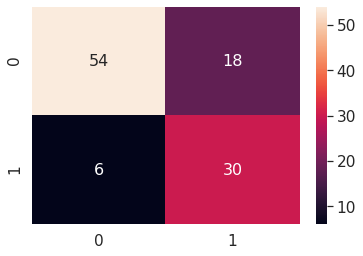

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        72
           1       0.62      0.83      0.71        36

    accuracy                           0.78       108
   macro avg       0.76      0.79      0.77       108
weighted avg       0.81      0.78      0.78       108

0.7916666666666666


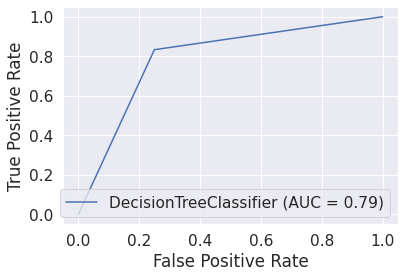

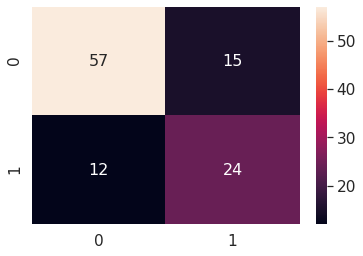

              precision    recall  f1-score   support

           0       0.83      0.79      0.81        72
           1       0.62      0.67      0.64        36

    accuracy                           0.75       108
   macro avg       0.72      0.73      0.72       108
weighted avg       0.76      0.75      0.75       108

0.7291666666666665


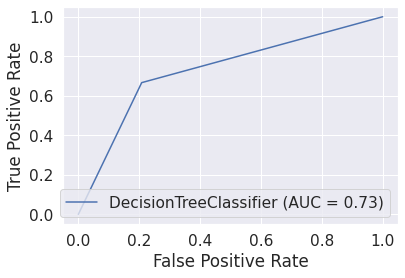

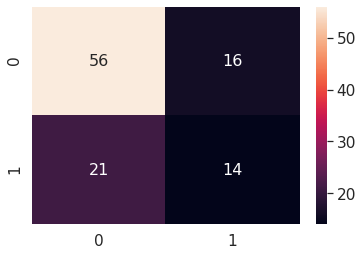

              precision    recall  f1-score   support

           0       0.73      0.78      0.75        72
           1       0.47      0.40      0.43        35

    accuracy                           0.65       107
   macro avg       0.60      0.59      0.59       107
weighted avg       0.64      0.65      0.65       107

0.5888888888888888


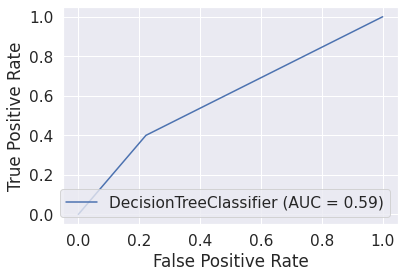

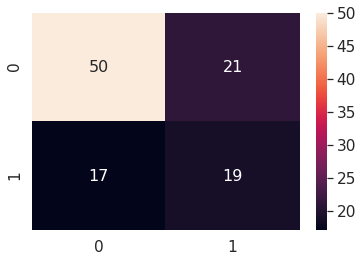

              precision    recall  f1-score   support

           0       0.75      0.70      0.72        71
           1       0.47      0.53      0.50        36

    accuracy                           0.64       107
   macro avg       0.61      0.62      0.61       107
weighted avg       0.66      0.64      0.65       107

0.6160015649452268


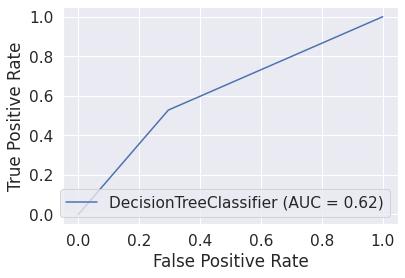

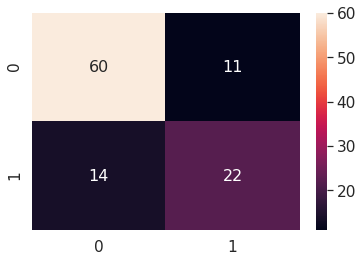

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        71
           1       0.67      0.61      0.64        36

    accuracy                           0.77       107
   macro avg       0.74      0.73      0.73       107
weighted avg       0.76      0.77      0.76       107

0.7280907668231612


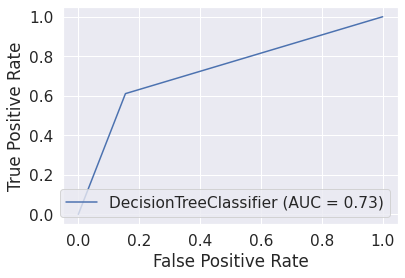

AUCS: [0.7916666666666666, 0.7291666666666665, 0.5888888888888888, 0.6160015649452268, 0.7280907668231612]
mean AUCS: 0.6907629107981219
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        72
           1       0.62      0.83      0.71        36

    accuracy                           0.78       108
   macro avg       0.76      0.79      0.77       108
weighted avg       0.81      0.78      0.78       108

              precision    recall  f1-score   support

           0       0.83      0.79      0.81        72
           1       0.62      0.67      0.64        36

    accuracy                           0.75       108
   macro avg       0.72      0.73      0.72       108
weighted avg       0.76      0.75      0.75       108

              precision    recall  f1-score   support

           0       0.73      0.78      0.75        72
           1       0.47      0.40      0.43        35

    accuracy                           0.65  

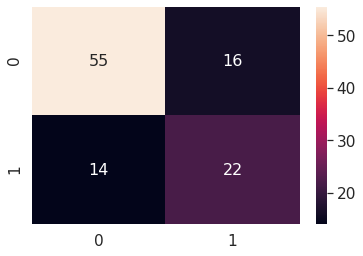

In [10]:
#cross validate decision tree
classifier = DecisionTreeClassifier()
my_cross_validate(classifier)

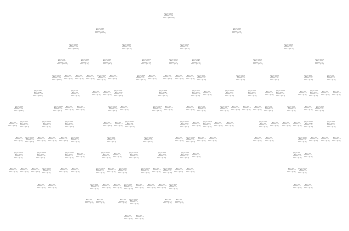

In [11]:
#print an example decision tree
from sklearn import tree
tree.plot_tree(classifier);

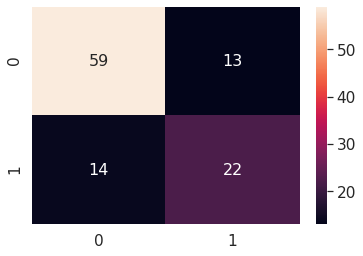

              precision    recall  f1-score   support

           0       0.81      0.82      0.81        72
           1       0.63      0.61      0.62        36

    accuracy                           0.75       108
   macro avg       0.72      0.72      0.72       108
weighted avg       0.75      0.75      0.75       108

0.8398919753086419


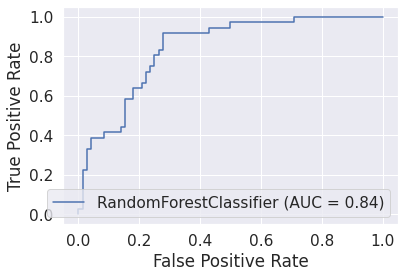

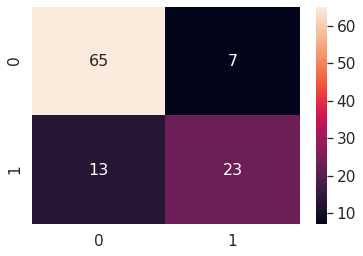

              precision    recall  f1-score   support

           0       0.83      0.90      0.87        72
           1       0.77      0.64      0.70        36

    accuracy                           0.81       108
   macro avg       0.80      0.77      0.78       108
weighted avg       0.81      0.81      0.81       108

0.8665123456790124


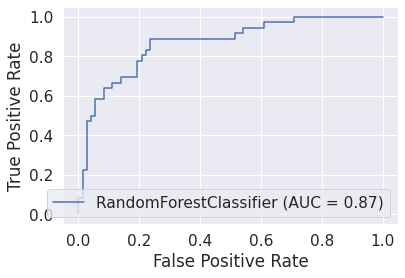

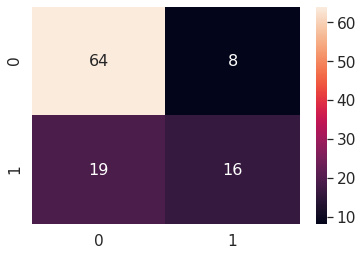

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        72
           1       0.67      0.46      0.54        35

    accuracy                           0.75       107
   macro avg       0.72      0.67      0.68       107
weighted avg       0.74      0.75      0.73       107

0.8412698412698413


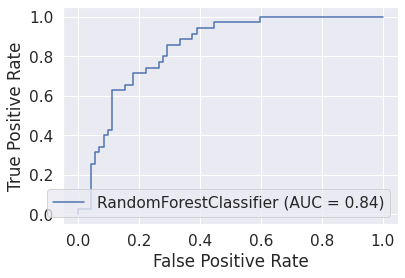

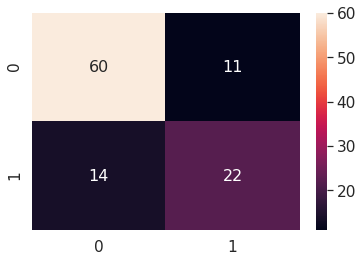

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        71
           1       0.67      0.61      0.64        36

    accuracy                           0.77       107
   macro avg       0.74      0.73      0.73       107
weighted avg       0.76      0.77      0.76       107

0.8337245696400625


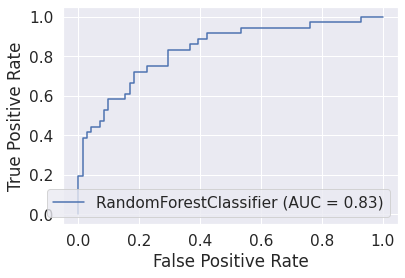

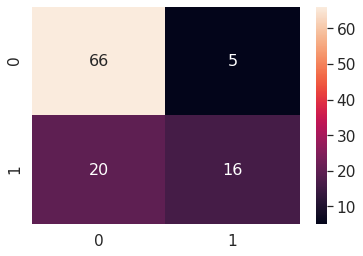

              precision    recall  f1-score   support

           0       0.77      0.93      0.84        71
           1       0.76      0.44      0.56        36

    accuracy                           0.77       107
   macro avg       0.76      0.69      0.70       107
weighted avg       0.77      0.77      0.75       107

0.8399843505477308


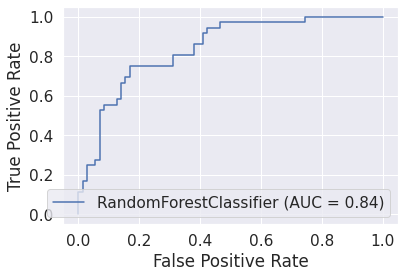

AUCS: [0.8398919753086419, 0.8665123456790124, 0.8412698412698413, 0.8337245696400625, 0.8399843505477308]
mean AUCS: 0.8442766164890578
              precision    recall  f1-score   support

           0       0.81      0.82      0.81        72
           1       0.63      0.61      0.62        36

    accuracy                           0.75       108
   macro avg       0.72      0.72      0.72       108
weighted avg       0.75      0.75      0.75       108

              precision    recall  f1-score   support

           0       0.83      0.90      0.87        72
           1       0.77      0.64      0.70        36

    accuracy                           0.81       108
   macro avg       0.80      0.77      0.78       108
weighted avg       0.81      0.81      0.81       108

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        72
           1       0.67      0.46      0.54        35

    accuracy                           0.75  

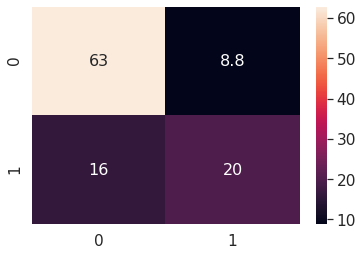

In [22]:
#cross validate random forest
classifier = RandomForestClassifier(max_depth = 4, criterion="entropy", n_estimators=200)
my_cross_validate(classifier)

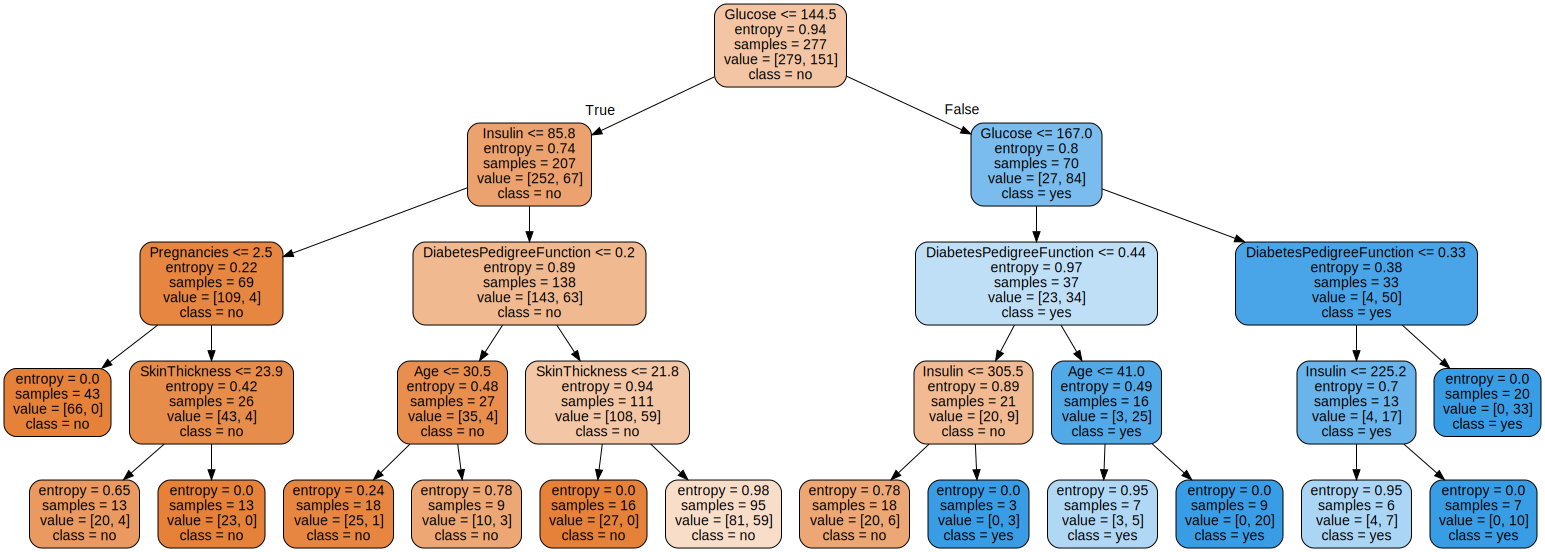

In [13]:
#example tree from random forest
from sklearn.tree import export_graphviz
import graphviz
dot_data = export_graphviz(classifier.estimators_[5], out_file=None, feature_names = diabetes_data.iloc[:,:-1].columns,
                class_names = ["no", "yes"],
                rounded = True, proportion = False, precision = 2, filled = True)

graph = graphviz.Source(dot_data, format="png")
graph.save('decision_tree.dot')
from graphviz import render
render('dot', 'png', 'decision_tree.dot')
graph


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


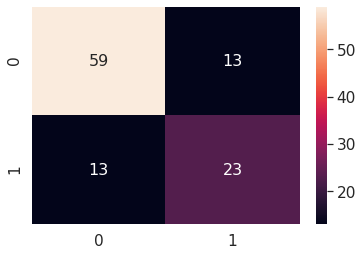

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        72
           1       0.64      0.64      0.64        36

    accuracy                           0.76       108
   macro avg       0.73      0.73      0.73       108
weighted avg       0.76      0.76      0.76       108

0.8499228395061729


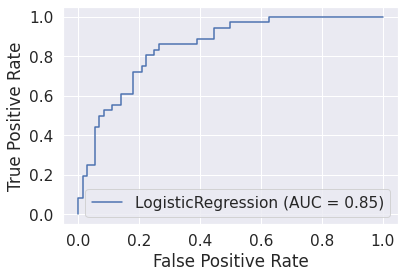

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


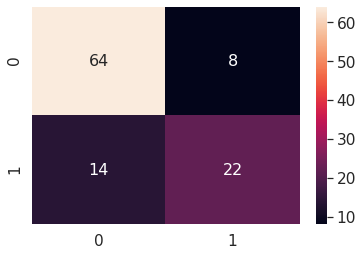

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        72
           1       0.73      0.61      0.67        36

    accuracy                           0.80       108
   macro avg       0.78      0.75      0.76       108
weighted avg       0.79      0.80      0.79       108

0.8260030864197531


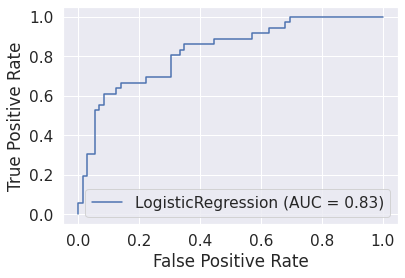

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


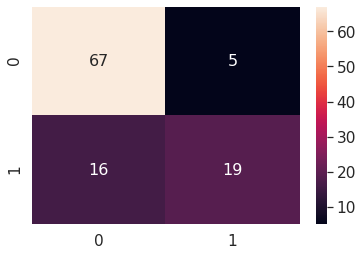

              precision    recall  f1-score   support

           0       0.81      0.93      0.86        72
           1       0.79      0.54      0.64        35

    accuracy                           0.80       107
   macro avg       0.80      0.74      0.75       107
weighted avg       0.80      0.80      0.79       107

0.8619047619047618


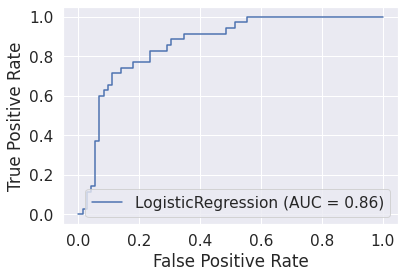

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


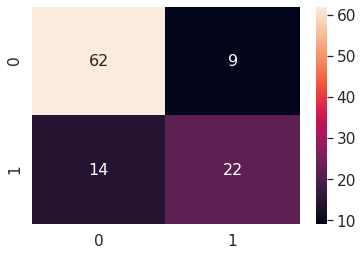

              precision    recall  f1-score   support

           0       0.82      0.87      0.84        71
           1       0.71      0.61      0.66        36

    accuracy                           0.79       107
   macro avg       0.76      0.74      0.75       107
weighted avg       0.78      0.79      0.78       107

0.8192488262910798


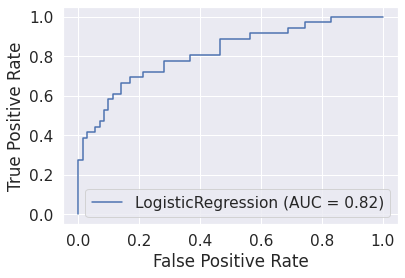

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


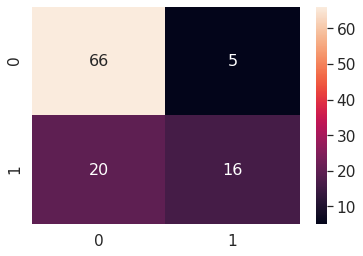

              precision    recall  f1-score   support

           0       0.77      0.93      0.84        71
           1       0.76      0.44      0.56        36

    accuracy                           0.77       107
   macro avg       0.76      0.69      0.70       107
weighted avg       0.77      0.77      0.75       107

0.8024256651017214


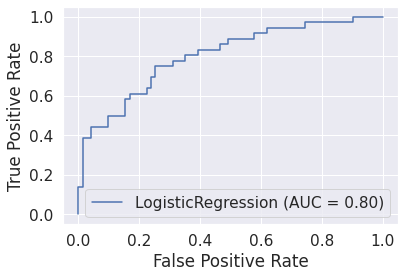

AUCS: [0.8499228395061729, 0.8260030864197531, 0.8619047619047618, 0.8192488262910798, 0.8024256651017214]
mean AUCS: 0.8319010358446979
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        72
           1       0.64      0.64      0.64        36

    accuracy                           0.76       108
   macro avg       0.73      0.73      0.73       108
weighted avg       0.76      0.76      0.76       108

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        72
           1       0.73      0.61      0.67        36

    accuracy                           0.80       108
   macro avg       0.78      0.75      0.76       108
weighted avg       0.79      0.80      0.79       108

              precision    recall  f1-score   support

           0       0.81      0.93      0.86        72
           1       0.79      0.54      0.64        35

    accuracy                           0.80  

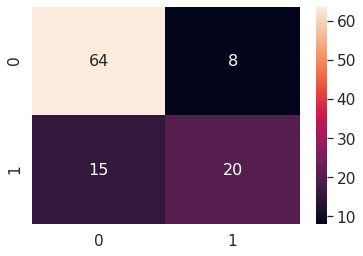

In [14]:
#cross validate logistic regression
classifier = LogisticRegression()
my_cross_validate(classifier)

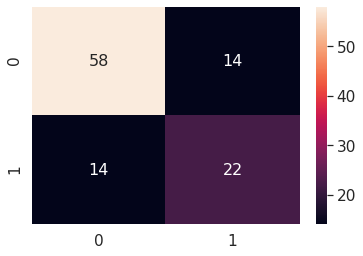

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        72
           1       0.61      0.61      0.61        36

    accuracy                           0.74       108
   macro avg       0.71      0.71      0.71       108
weighted avg       0.74      0.74      0.74       108

0.8310185185185186


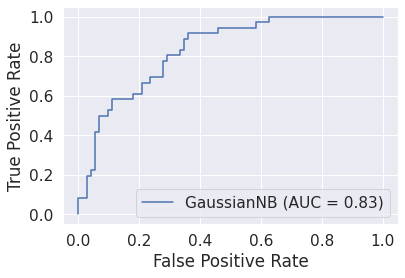

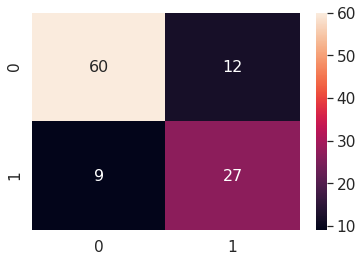

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        72
           1       0.69      0.75      0.72        36

    accuracy                           0.81       108
   macro avg       0.78      0.79      0.79       108
weighted avg       0.81      0.81      0.81       108

0.8923611111111112


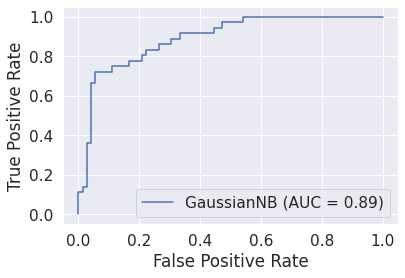

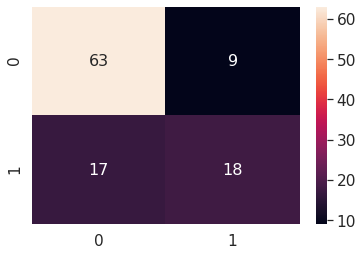

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        72
           1       0.67      0.51      0.58        35

    accuracy                           0.76       107
   macro avg       0.73      0.69      0.70       107
weighted avg       0.75      0.76      0.75       107

0.8337301587301588


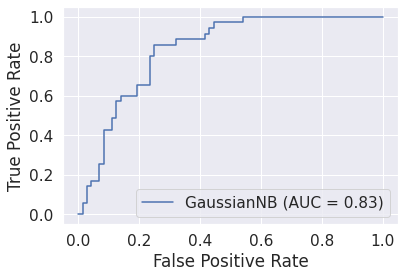

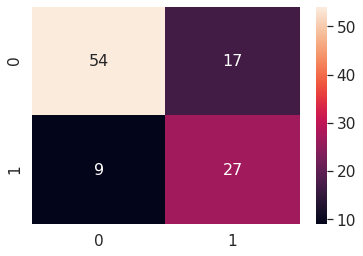

              precision    recall  f1-score   support

           0       0.86      0.76      0.81        71
           1       0.61      0.75      0.67        36

    accuracy                           0.76       107
   macro avg       0.74      0.76      0.74       107
weighted avg       0.78      0.76      0.76       107

0.8251173708920188


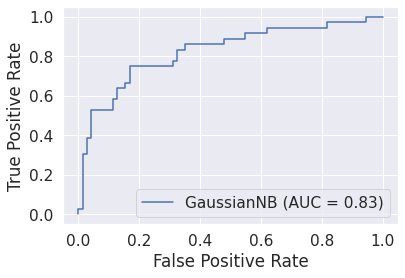

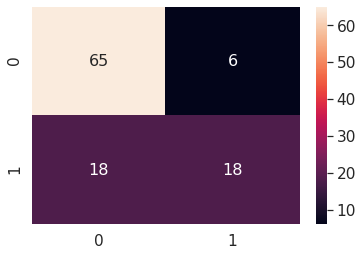

              precision    recall  f1-score   support

           0       0.78      0.92      0.84        71
           1       0.75      0.50      0.60        36

    accuracy                           0.78       107
   macro avg       0.77      0.71      0.72       107
weighted avg       0.77      0.78      0.76       107

0.8360719874804382


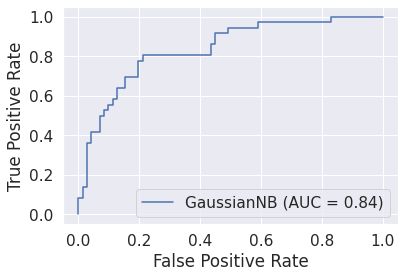

AUCS: [0.8310185185185186, 0.8923611111111112, 0.8337301587301588, 0.8251173708920188, 0.8360719874804382]
mean AUCS: 0.8436598293464492
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        72
           1       0.61      0.61      0.61        36

    accuracy                           0.74       108
   macro avg       0.71      0.71      0.71       108
weighted avg       0.74      0.74      0.74       108

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        72
           1       0.69      0.75      0.72        36

    accuracy                           0.81       108
   macro avg       0.78      0.79      0.79       108
weighted avg       0.81      0.81      0.81       108

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        72
           1       0.67      0.51      0.58        35

    accuracy                           0.76  

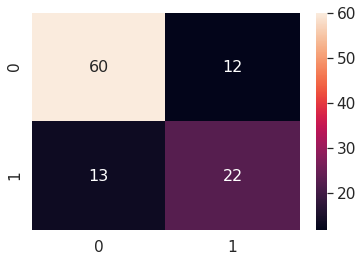

In [15]:
#cross validate naive bayes
classifier = GaussianNB()
my_cross_validate(classifier)

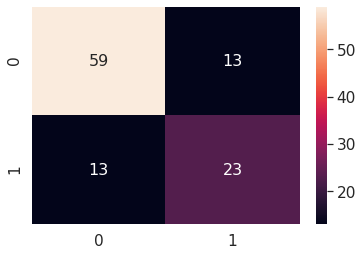

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        72
           1       0.64      0.64      0.64        36

    accuracy                           0.76       108
   macro avg       0.73      0.73      0.73       108
weighted avg       0.76      0.76      0.76       108

0.8479938271604939


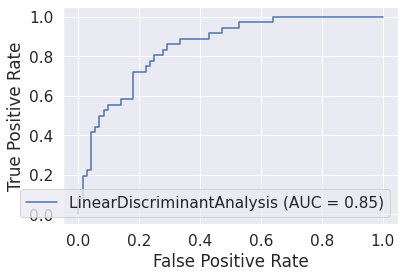

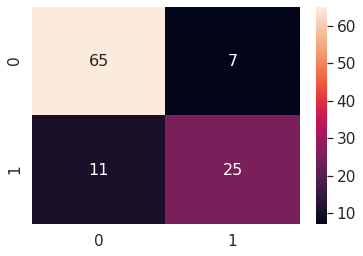

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        72
           1       0.78      0.69      0.74        36

    accuracy                           0.83       108
   macro avg       0.82      0.80      0.81       108
weighted avg       0.83      0.83      0.83       108

0.8746141975308641


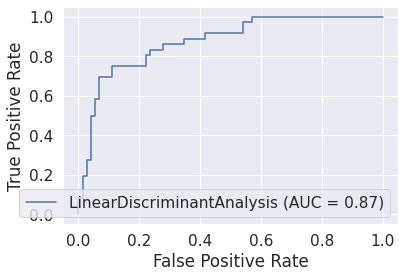

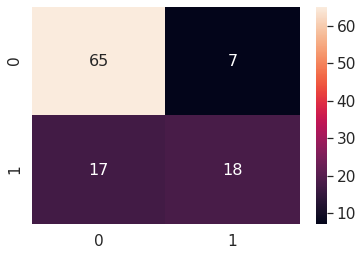

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        72
           1       0.72      0.51      0.60        35

    accuracy                           0.78       107
   macro avg       0.76      0.71      0.72       107
weighted avg       0.77      0.78      0.76       107

0.8623015873015872


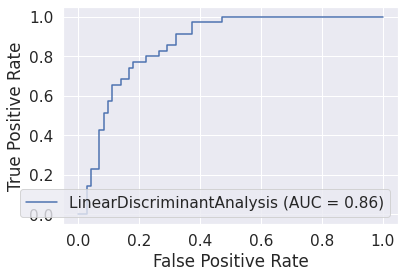

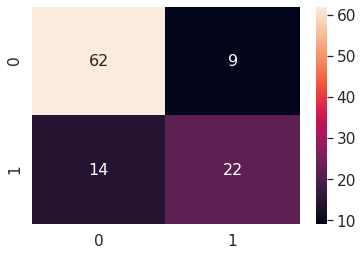

              precision    recall  f1-score   support

           0       0.82      0.87      0.84        71
           1       0.71      0.61      0.66        36

    accuracy                           0.79       107
   macro avg       0.76      0.74      0.75       107
weighted avg       0.78      0.79      0.78       107

0.8165101721439749


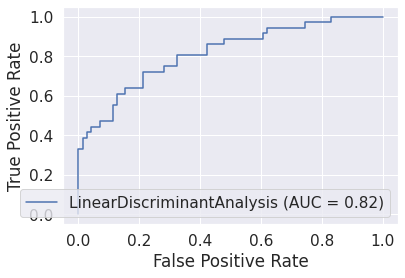

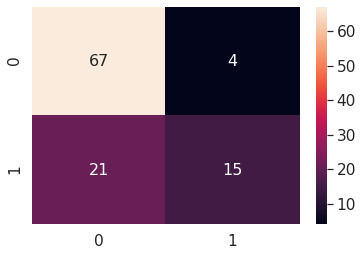

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        71
           1       0.79      0.42      0.55        36

    accuracy                           0.77       107
   macro avg       0.78      0.68      0.69       107
weighted avg       0.77      0.77      0.74       107

0.837245696400626


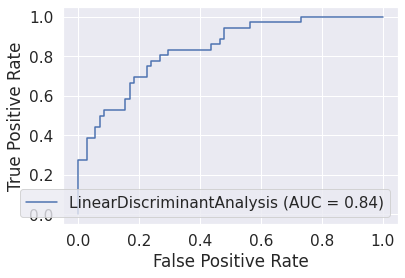

AUCS: [0.8479938271604939, 0.8746141975308641, 0.8623015873015872, 0.8165101721439749, 0.837245696400626]
mean AUCS: 0.8477330961075094
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        72
           1       0.64      0.64      0.64        36

    accuracy                           0.76       108
   macro avg       0.73      0.73      0.73       108
weighted avg       0.76      0.76      0.76       108

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        72
           1       0.78      0.69      0.74        36

    accuracy                           0.83       108
   macro avg       0.82      0.80      0.81       108
weighted avg       0.83      0.83      0.83       108

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        72
           1       0.72      0.51      0.60        35

    accuracy                           0.78   

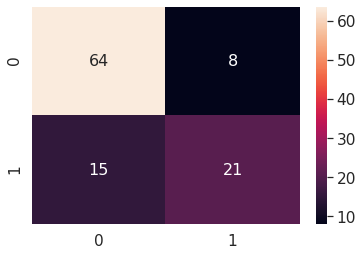

In [16]:
#cross validate linear discriminant analysis
classifier = LinearDiscriminantAnalysis()
my_cross_validate(classifier)

              precision    recall  f1-score   support

           0       0.74      0.89      0.81       142
           1       0.74      0.51      0.60        89

    accuracy                           0.74       231
   macro avg       0.74      0.70      0.70       231
weighted avg       0.74      0.74      0.73       231



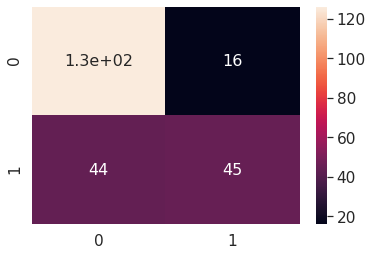

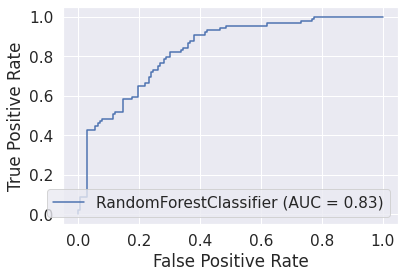

In [17]:
#building the model that I chose, random forest, and hyper paremeter tuning it
classifier = RandomForestClassifier(max_depth = 4, criterion="entropy", n_estimators=200)

#imputing the values for the final time
my_imputer = KNNImputer()
new_diabetes_data = pd.DataFrame(my_imputer.fit_transform(x_train))
new_diabetes_data.columns = x_train.columns
new_diabetes_data.index = x_train.index
x_train = new_diabetes_data

new_diabetes_data = pd.DataFrame(my_imputer.fit_transform(x_test))
new_diabetes_data.columns = x_test.columns
new_diabetes_data.index = x_test.index
x_test = new_diabetes_data

#fitting the classifier to the data
classifier.fit(x_train, y_train)

#printing metrics one last time
from sklearn.metrics import confusion_matrix
y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

metrics.plot_roc_curve(classifier, x_test, y_test)
plt.show()

In [18]:
#exporting the model to be used in my cds application
pickle.dump(classifier, open("diabetes_predictor.pkl", "wb"))